https://docs.opencv.org/4.5.0/d3/dc0/group__imgproc__shape.html

# Crater Detection & Identification

## Imports & Data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import torch
import sklearn.neighbors
import h5py

from VPU import OpenVINOHandler
from craterdetection.deepmoon import template_match_t, DeepMoon

sd_input_images = np.load('../blobs/sd_input_images.npy').transpose(0, 3, 1, 2)
sd_target_masks = np.load('../blobs/sd_target_masks.npy')
h5_craters = h5py.File("D:\Downloads\Chrome\dev_craters.hdf5", "r")
h5_images = h5py.File("D:\Downloads\Chrome\dev_images.hdf5", "r")

## Setup Model

In [2]:
net = DeepMoon()
checkpoint_path = '../blobs/DeepMoon.pth'
checkpoint = torch.load(checkpoint_path)
net.load_state_dict(checkpoint)
net.eval()

exp = OpenVINOHandler('DeepMoon', device='CPU', root='../VPU/IR/')
exp

OpenVINOHandler(device=CPU, input_layout=NCHW, input_shape=(1, 1, 256, 256))

## Output Post-Processing

### Skeletonise or Thinning Function
Works, but reduces the amount of detected craters; May be useful in future when assessing crater matching performance.

In [3]:
def skeletonise(img_threshold):
    img = img_threshold.copy()
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while( not done):
        eroded = cv2.erode(img, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True

    return skel

### Crater Detection
Utilises thresholding + contour finding + ellipse fitting to return discrete crater detections with ellipticity < 0.1.

In [523]:
def crater_detection(mask, threshold_lower=80):
    mask = np.uint8(mask*255)
    ret, thresh = cv2.threshold(mask, threshold_lower, 255, 0)
    # thresh = skeletonise(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if (len(cnt) >= 5)]

    convex_hulls = [cv2.convexHull(cnt) for cnt in contours]
    ellipses = [cv2.fitEllipse(cnt) for cnt in convex_hulls if len(cnt) >= 5]

    ellipses_arr = np.array([[e[0][0], e[0][1], e[1][0]/2, e[1][1]/2, e[2]] for e in ellipses])
    df_detections = pd.DataFrame(ellipses_arr, columns=['x_pix', 'y_pix', 'a_pix', 'b_pix', 'angle_pix'])

    # Remove detections based on ellipticity
    def ellipticity(a, b):
        return (a-b)/a if a >= b else (b-a)/b

    df_detections['e'] = df_detections.apply(lambda row: ellipticity(row['a_pix'], row['b_pix']), axis=1)
    df_detections.query('e <= 0.1', inplace=True)
    df_detections.reset_index(inplace=True, drop=True)
    
    # Remove duplicate craters (based on position)
    xy = df_detections[['x_pix', 'y_pix']].to_numpy()
    dist = cdist(xy, xy, 'euclidean')

    duplicates = np.array(np.where(np.bitwise_and(dist > 0, dist < 2))).T[::2]
    df_detections.drop(index=duplicates[:, 0], inplace=True)
    df_detections.reset_index(inplace=True, drop=True)
    
    df_detections.eval('r_pix = (a_pix + b_pix)/2', inplace=True)

    # Possible TODO: add another filter based on crater size    

    return df_detections

def draw_detections(df, shape=(256, 256)):
    img_ellipses = np.zeros(shape)
    for i, r in df.iterrows():
        center_coordinates = (round(r['x_pix']), round(r['y_pix']))
        axes_length = (round(r['a_pix']), round(r['b_pix']))
        angle = round(r['angle_pix'])
        img_ellipses = cv2.ellipse(img_ellipses, center_coordinates, axes_length, 
                   angle, 0, 360, (255, 255, 255), 1)
        img_ellipses = cv2.circle(img_ellipses, center_coordinates, 0, (255,255,255), 1)
    
    return img_ellipses

### Test

In [524]:
image_i = 10
crater_test = h5_craters[f'img_{image_i:05}/block0_values'][...]
df_target = pd.DataFrame(crater_test, columns=['diam', 'lat', 'long', 'x_pix', 'y_pix', 'diam_pix'])
img_test = h5_images['input_images'][image_i]/255
df_target.eval('kmperpix = diam / diam_pix', inplace=True)

target_mask = np.zeros_like(img_test)
for i, r in df_target.iterrows():
    center_coordinates = (round(r['x_pix']), round(r['y_pix']))
    axes_length = (round(r['diam_pix']/2), round(r['diam_pix']/2))
    angle = 0
    target_mask = cv2.ellipse(img_ellipses, center_coordinates, axes_length, 
               angle, 0, 360, (255, 255, 255), 1)

In [525]:
batch = torch.Tensor(img_test.reshape(1, 1, 256, 256))
with torch.no_grad():
    out = net(batch)

47 craters detected!


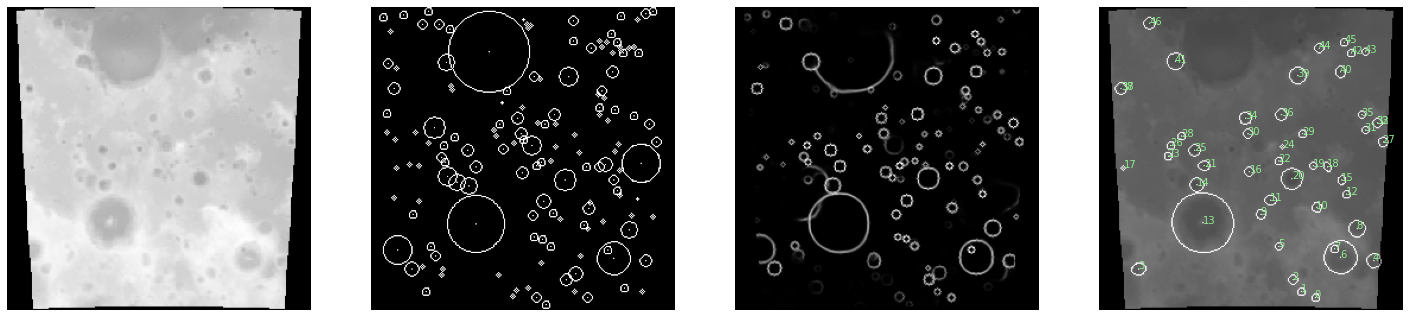

In [526]:
df_detections = crater_detection(out[0, 0], threshold_lower=80)

img_out = [
    batch[0, 0],
    target_mask,
    out[0, 0],
    255*batch[0, 0]+draw_detections(df_detections)
]

fig, axes = plt.subplots(1, len(img_out), figsize=(25, 15))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    
for index, r in df_detections.iterrows():
    axes[-1].text(r['x_pix'], r['y_pix'], str(index), color='lightgreen')

print(f"{len(df_detections)} craters detected!")
# df_detections

# Crater Matching

In [527]:
def LatLongToWorld(lat, lon, alt=0, rad=1737.1):
    # see: http://www.mathworks.de/help/toolbox/aeroblks/llatoecefposition.html
    f  = 1./825.                              # flattening
    ls = np.arctan((1 - f)**2 * np.tan(lat))    # lambda

    x = rad * np.cos(ls) * np.cos(lon) + alt * np.cos(lat) * np.cos(lon)
    y = rad * np.cos(ls) * np.sin(lon) + alt * np.cos(lat) * np.sin(lon)
    z = rad * np.sin(ls) + alt * np.sin(lat)

    return x, y, z

## Crater Database

In [528]:
df_craters  = pd.read_csv("../data/lunar_crater_database_robbins_2018.csv")
df_craters.query('(DIAM_CIRC_IMG < 40) & (DIAM_CIRC_IMG > 3)', inplace=True)

In [536]:
latlong = df_craters[['LAT_CIRC_IMG', 'LON_CIRC_IMG']].to_numpy()
lat, long = latlong[:, 0], latlong[:, 1]
x, y, z = LatLongToWorld(lat, long)
diam = df_craters['DIAM_CIRC_IMG'].to_numpy()

A = sklearn.neighbors.kneighbors_graph(np.array([x, y, z]).T, 300, mode='distance', metric='euclidean', n_jobs=-1)
sparsity = 1 - A.count_nonzero() / abs(np.multiply(*A.shape))

row, col = A.nonzero()
data = np.array(A[row, col]).ravel()

print(f'{repr(A)}\nSparsity: {sparsity}')

<209817x209817 sparse matrix of type '<class 'numpy.float64'>'
	with 62945100 stored elements in Compressed Sparse Row format>
Sparsity: 0.9413646343904131


## Ground Truth

In [530]:
test_xyz = LatLongToWorld(df_target['lat'].to_numpy(), df_target['long'].to_numpy())
df_target[['x_MCMF', 'y_MCMF', 'z_MCMF']] = np.array(test_xyz).T
df_target.describe()

,diam,lat,long,x_pix,y_pix,diam_pix,kmperpix,x_MCMF,y_MCMF,z_MCMF
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,1.480000e+02,148.000000,148.000000,148.000000
mean,13.116574,-25.995429,35.357873,136.513362,118.946826,7.476908,1.754278e+00,-239.695606,-33.956408,-55.142920
std,13.113537,4.070360,4.320720,67.541129,70.306751,7.475177,2.722561e-16,787.145339,852.434423,1276.610499
min,5.012686,-33.715383,27.503885,10.307271,3.537621,2.857407,1.754278e+00,-1729.695812,-1700.088274,-1736.976018
25%,6.964821,-29.225209,31.093648,69.309102,60.210370,3.970193,1.754278e+00,-894.505081,-592.519211,-1346.427349
50%,9.577130,-25.864435,35.856260,143.535326,116.593354,5.459300,1.754278e+00,-275.942489,2.510896,-142.845009
75%,13.786529,-22.665143,39.156338,196.264525,175.369037,7.858806,1.754278e+00,297.973784,602.064021,1255.249369
max,118.284842,-19.221127,42.024097,239.521549,251.357504,67.426514,1.754278e+00,1671.896882,1680.217264,1737.099411


## Detections

In [531]:
kmperpix = df_target.iloc[0]['kmperpix'] # cheats

x_det = df_detections['x_pix'].to_numpy()
y_det = df_detections['y_pix'].to_numpy()

### Pole Crater Extraction

In [532]:
xy_det = np.array((x_det, y_det)).T

center = np.array([[128., 128.]])
pole_index = np.argmin(cdist(center, xy_det, 'euclidean'))
pole_m = np.array([xy_det[pole_index]])
xy_satellite = np.delete(xy_det, pole_index, axis=0)
theta = cdist(pole_m, xy_satellite, 'euclidean').squeeze()

df_detections.iloc[pole_index]

x_pix        126.500000
y_pix        139.494980
a_pix          4.362303
b_pix          4.437586
angle_pix      0.000000
e              0.016965
r_pix          4.399944
Name: 16, dtype: float64

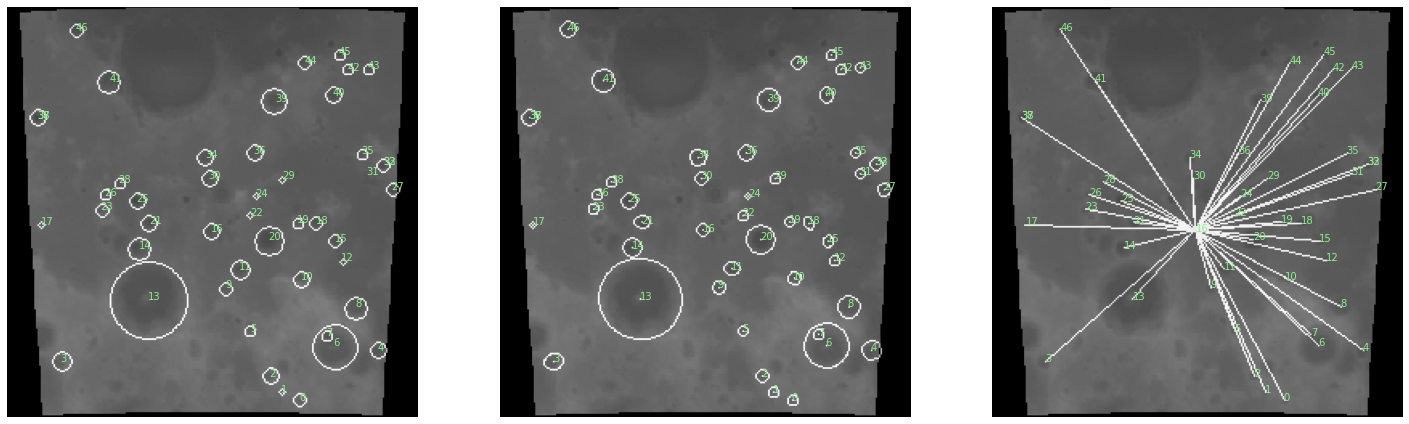

In [537]:
xy_target = df_target[['x_pix', 'y_pix']].to_numpy()
df_target_matched = df_target.iloc[np.argmin(cdist(xy_det, xy_target), axis=1)]

img_pole = np.zeros_like(batch[0, 0])
for pos in xy_satellite:
    # Draw a diagonal blue line with thickness of 5 px
    cv2.line(img_pole, tuple(np.uint(pole_m.round().squeeze())), tuple(np.uint(np.round(pos))), (255,1,0), 1)
    
img_target_matched = np.zeros_like(batch[0, 0])
for index, r in df_target_matched.iterrows():
    center_coordinates = (round(r['x_pix']), round(r['y_pix']))
    axes_length = (round(r['diam_pix']/2), round(r['diam_pix']/2))
    angle = 0
    img_target_matched = cv2.ellipse(img_target_matched, center_coordinates, axes_length, 
               angle, 0, 360, (255, 255, 255), 1)

img_out = [
    255*batch[0, 0]+img_target_matched,
    255*batch[0, 0]+draw_detections(df_detections),
    255*batch[0, 0]+img_pole
]

fig, axes = plt.subplots(1, len(img_out), figsize=(25, 15))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    for index, r in df_detections.iterrows():
        ax.text(r['x_pix'], r['y_pix'], str(index), color='lightgreen')

In [540]:
%%time
closest_order = np.argsort(theta)

err_dist = 1

diam_det = df_detections.iloc[pole_index].r_pix*2*kmperpix
err_diam = 2

unique_list = []
counts_list = []

diam_row, diam_col = diam[row], diam[col]
mask_diam = np.bitwise_and(diam_row > diam_det-err_diam, diam_row < diam_det+err_diam)
row_f, col_f = row[mask_diam], col[mask_diam]
data_f = data[mask_diam]
diam_row, diam_col = diam_row[row_f], diam_col[col_f]

for theta_ij, (index, det) in zip(theta[closest_order]*kmperpix, df_detections.iloc[closest_order].iterrows()):
    diam_j = det.r_pix * 2 * kmperpix
    mask_diam_col = np.bitwise_and(diam_col > diam_j-err_diam, diam_col < diam_j+err_diam)
    
    row_ff, col_ff = row_f[mask_diam_col], col_f[mask_diam_col]
    data_ff = data_f[mask_diam_col]
    # Filter world data based on detected pair distance
    mask_dist = np.bitwise_and(data_ff > theta_ij-err_dist, data_ff < theta_ij+err_dist)

    row_fff, col_fff = row_ff[mask_dist], col_ff[mask_dist]
    data_fff = data_ff[mask_dist]

    unique, counts = np.unique(row_fff, return_counts=True)
    unique_list.append(unique)
    counts_list.append(counts)
    
candidates = {}
for u, c in zip(unique_list, counts_list):
    for ui, ci, in zip(u, c):
        if ui not in candidates.keys():
            candidates[ui] = ci
        else:
            candidates[ui] += ci
print(f"({max(candidates, key=candidates.get)}: {max(candidates.values())})")

df_craters.iloc[max(candidates, key=candidates.get)]

(18244: 23)
Wall time: 2.36 s


CRATER_ID                 02-1-000594
LAT_CIRC_IMG                  48.0896
LON_CIRC_IMG                   262.54
LAT_ELLI_IMG                   48.092
LON_ELLI_IMG                  262.553
DIAM_CIRC_IMG                 13.8837
DIAM_CIRC_SD_IMG             0.405237
DIAM_ELLI_MAJOR_IMG           15.4108
DIAM_ELLI_MINOR_IMG           12.9607
DIAM_ELLI_ECCEN_IMG           0.54101
DIAM_ELLI_ELLIP_IMG           1.18904
DIAM_ELLI_ANGLE_IMG           25.7699
LAT_ELLI_SD_IMG           0.000445582
LON_ELLI_SD_IMG            0.00102299
DIAM_ELLI_MAJOR_SD_IMG      0.0556496
DIAM_ELLI_MINOR_SD_IMG      0.0316519
DIAM_ELLI_ANGLE_SD_IMG        0.67457
DIAM_ELLI_ECCEN_SD_IMG     0.00569935
DIAM_ELLI_ELLIP_SD_IMG     0.00518343
ARC_IMG                       0.85609
PTS_RIM_IMG                       181
Name: 133947, dtype: object

## Cython Test

In [547]:
%load_ext Cython

In [548]:
%%cython
cdef void mandel_single_point(double complex *z_in, 
                              double complex *c_in,
                              double complex *z_out) nogil:
    #
    # The Mandelbrot iteration
    #

    #
    # Some points of note:
    #
    # - It's *NOT* allowed to call any Python functions here.
    #
    #   The Ufunc loop runs with the Python Global Interpreter Lock released.
    #   Hence, the ``nogil``.
    #
    # - And so all local variables must be declared with ``cdef``
    #
    # - Note also that this function receives *pointers* to the data;
    #   the "traditional" solution to passing complex variables around
    #

    cdef double complex z = z_in[0]
    cdef double complex c = c_in[0]
    cdef int k  # the integer we use in the for loop

    # Straightforward iteration

    for k in range(100):
        z = z*z + c
        if z.real**2 + z.imag**2 > 1000:
            break

    # Return the answer for this point
    z_out[0] = z

In [514]:
xy_target = df_target[['x_pix', 'y_pix']].to_numpy()
df_target.iloc[np.argmin(cdist(xy_det, xy_target), axis=1)]

,diam,lat,long,x_pix,y_pix,diam_pix,kmperpix,x_MCMF,y_MCMF,z_MCMF
2,12.293408,-33.314237,38.550446,182.310516,245.150365,7.007675,1.754278,369.045455,421.228859,1644.350361
4,7.449324,-33.048418,37.764265,171.023486,240.279602,4.246376,1.754278,107.133730,6.989951,1733.779085
10,15.898079,-32.447786,37.242207,163.653828,229.774611,9.062463,1.754278,801.500487,-394.017261,-1489.920728
15,22.335637,-31.805043,28.414942,33.521242,220.698766,12.732098,1.754278,-1591.934945,-225.326273,-657.637903
18,18.930501,-31.405188,41.762173,230.975330,214.226411,10.791050,1.754278,-1050.279159,-1383.504175,18.608975
24,12.195742,-30.839882,36.361875,151.125907,201.822022,6.952001,1.754278,337.400240,-1418.238769,944.603771
19,49.164553,-31.374878,39.910988,203.648106,212.421657,28.025522,1.754278,-1038.021410,1391.032293,71.113438
22,11.343873,-30.949624,39.582194,199.097854,204.894636,6.466406,1.754278,-476.951511,1477.317207,779.466187
29,23.884662,-29.942169,40.701569,216.648615,188.184709,13.615096,1.754278,-167.076261,23.397347,1728.888226
34,14.711545,-29.342412,35.340458,135.981870,175.796470,8.386098,1.754278,-594.372783,-591.456718,-1521.320596


# SpaceEngine test

10 craters detected!


,x,y,a,b,angle,e
0,134.430832,204.430832,2.358139,2.485638,135.000000,0.051294
1,163.500000,172.500000,2.549510,2.549510,0.000000,0.000000
2,67.500000,161.500000,2.549510,2.549510,0.000000,0.000000
3,211.730469,146.500000,2.551301,2.792993,90.000000,0.086535
4,44.500000,126.500000,2.549510,2.549510,0.000000,0.000000
5,221.500000,109.500000,2.549510,2.549510,0.000000,0.000000
6,210.940247,107.000000,2.028463,2.117456,0.000000,0.042028
7,174.952332,36.933552,2.974316,3.056455,112.231094,0.026874
8,113.741692,25.998363,3.925573,3.994529,175.959106,0.017263
9,216.500000,8.500000,1.581139,1.581139,0.000000,0.000000


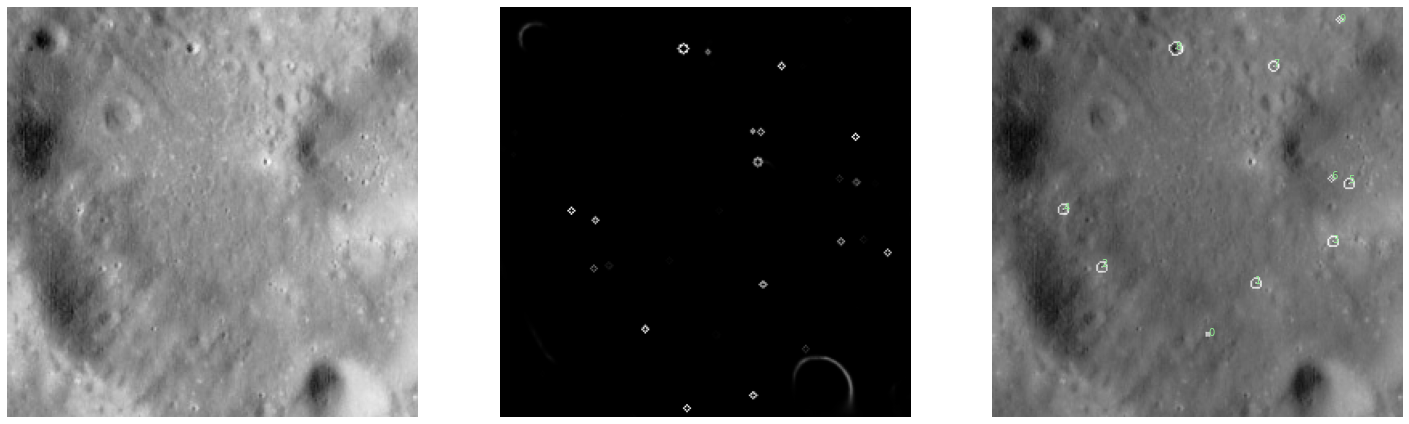

In [120]:
# Image metadata
img = cv2.imread('../data/scr00020.jpg', cv2.IMREAD_GRAYSCALE)
lat, long = (-78.40696667, -42.517858) #scr00003
h = 86.52 #km
fov = 45 #degrees (vertical FOV uncropped image)

# Crop center of screenshot to input shape 
ysize, xsize = img.shape
_, _, x_in, y_in = exp.input_shape
img = img[(ysize//2)-(y_in//2):(ysize//2)+(y_in//2), (xsize//2)-(x_in//2):(xsize//2)+(x_in//2)]

# Image dimension
d = 2*(y_in/ysize)*h*np.tan(np.deg2rad(fov/2)) 
fov_crop = np.rad2deg(np.arctan(d/h))
batch = transforms.ToTensor()(img.copy()).unsqueeze_(0)
out = exp.infer(batch)

# Plot 
df_detections = crater_detection(out[0, 0], threshold_lower=1)

img_out = [
    batch[0, 0],
    out[0, 0],
    700*batch[0, 0]+draw_detections(df_detections)
]

fig, axes = plt.subplots(1, len(img_out), figsize=(25, 15))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    
for i, r in df_detections.iterrows():
    axes[-1].text(r['x'], r['y'], str(i), color='lightgreen')

print(f"{len(df_detections)} craters detected!")
df_detections